### Names

    -Adria Torija Ruiz

    -Corentin Lamboley

    -Jonathan Hailemariam

### Student ids: 

    -567212

    -566747

    -507244

### Kaggle competition name:

    -AdriaTorijaR

    -Corentin Lamboley

    -JonathanSHailemariam

### Kaggle team name:

    -Team 83

# Moscow Housing Prediction Notebook
### Short EDA

## Import libraries

In [41]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)


#RandomForest Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, cv

from sklearn.feature_selection import RFECV
from sklearn import model_selection
from timeit import default_timer as timer
import xgboost as xgb

from mlxtend.regressor import StackingCVRegressor

rfrmodel = RandomForestRegressor()
rfcmodel = RandomForestClassifier()

In [42]:
def RMSLE(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

# DataSets
## Loading Datasets

Train-Test Split : 

We already have a train/test split that will be used to evaluate your submission. Concretely, you are given:

~23k training samples with price data that you can use to select and fit models
~10k testing samples without price data that we will use to evaluate your models

The split have been desiged so that you can expect roughly the same distribution of data during evaluation. Specifically, we have made sure to stratify it with respect to the price range and location of apartments.

In [43]:
apartments = pd.read_csv('data/apartments_train.csv')
buildings = pd.read_csv('data/buildings_train.csv')
data_train = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data_train.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [44]:
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
data_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


# Missing data management
You can see on the cell below the distribution of missing data in the train and test set

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


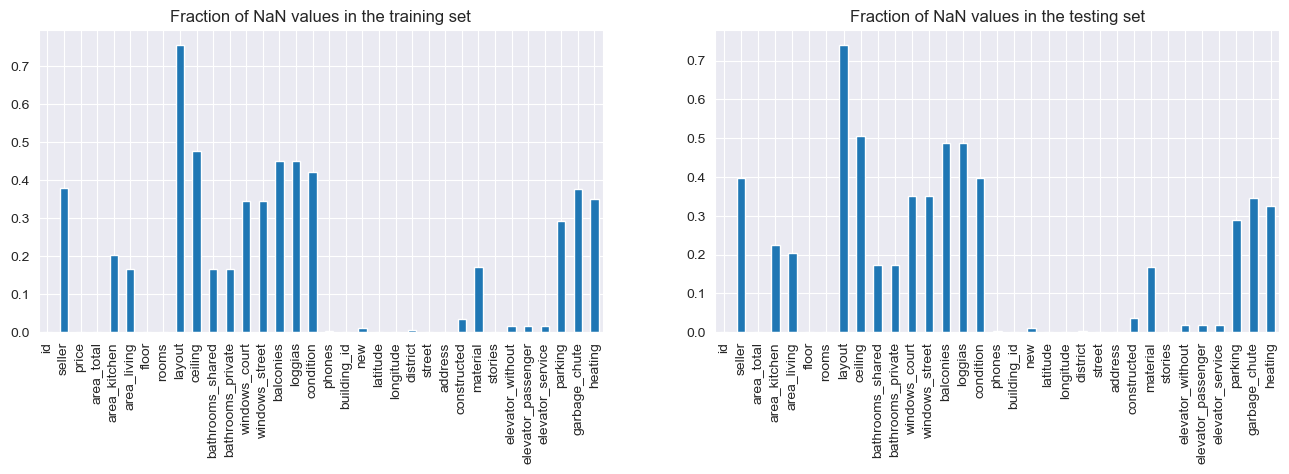

In [45]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data_train.price.isna().sum()}')
print(f'Training set features with any missing value: {data_train.isna().any().sum()}/{data_train.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

In [46]:
(data_train.isnull().sum()/23284).sort_values()

id                    0.000000
street                0.000000
price                 0.000000
area_total            0.000000
building_id           0.000000
longitude             0.000000
floor                 0.000000
rooms                 0.000000
stories               0.000000
address               0.000000
latitude              0.000000
phones                0.003436
district              0.005583
new                   0.011338
elevator_passenger    0.015332
elevator_without      0.015332
elevator_service      0.015332
constructed           0.034101
bathrooms_private     0.166294
bathrooms_shared      0.166294
area_living           0.166724
material              0.170589
area_kitchen          0.202757
parking               0.291531
windows_street        0.346676
windows_court         0.346676
heating               0.350498
garbage_chute         0.378414
seller                0.379230
condition             0.421319
loggias               0.451812
balconies             0.451812
ceiling 

### Removing features with too much missing data

In [47]:
data_train = data_train.drop(['layout','balconies','loggias','condition','garbage_chute','heating','windows_court','windows_street'],axis=1)
data_test = data_test.drop(['layout','balconies','loggias','condition','garbage_chute','heating','windows_court','windows_street'],axis=1)

In [48]:
data_train_filled = data_train.copy()
data_test_filled = data_test.copy()

pd.options.mode.chained_assignment = None

### For categorical Values 
We will fill the missing values with 'missing'

In [49]:
data_train_filled['phones'] = data_train_filled['phones'].fillna(0)
data_train_filled['seller'] = data_train_filled['seller'].fillna(4)
data_train_filled['parking'] = data_train_filled['parking'].fillna(3)
data_train_filled['elevator_service'] = data_train_filled['elevator_service'].fillna(2)
data_train_filled['elevator_passenger'] = data_train_filled['elevator_passenger'].fillna(2)
data_train_filled['elevator_without'] = data_train_filled['elevator_without'].fillna(2)

data_test_filled['phones'] = data_test_filled['phones'].fillna(0)
data_test_filled['seller'] = data_test_filled['seller'].fillna(4)
data_test_filled['parking'] = data_test_filled['parking'].fillna(3)
data_test_filled['elevator_service'] = data_test_filled['elevator_service'].fillna(2)
data_test_filled['elevator_passenger'] = data_test_filled['elevator_passenger'].fillna(2)
data_test_filled['elevator_without'] = data_test_filled['elevator_without'].fillna(2)

### There is 2 missing Latitude & Longitude in the Test set :
We will fill them using the 'street' feature

In [50]:
street=[]
for i in range(len(data_test_filled)):
    if(data_test_filled.isna()['longitude'][i]):
        street.append(data_test['street'][i])
long=0
latitude=0
total=0
for i in range(len(data_test_filled)):
    for j in range(len(street)):
        if(data_test_filled['street'][i] == street[j]):
            if(data_test_filled.isna()['longitude'][i] == False):
                long=+data_test_filled['longitude'][i]
                latitude=+ data_test_filled['latitude'][i]
                total=+1
long=long/total
latitude= latitude/total

for i in range(len(data_test_filled)):                
    if(long!=0):
        if(data_test_filled.isna()['longitude'][i]):
            data_test_filled['longitude'][i] = long
            data_test_filled['latitude'][i] = latitude

# Using Random Forest for other features :

### Area Living
#### Fixing Wrong Values :
Some values are under 1 meter, or even equal to zero.
We need to change those value because later we will apply the log10 transformation to area_living.

In [51]:
for index in range(len(data_train_filled['id'])):
    if data_train_filled['area_living'][index] < 1:
        data_train_filled['area_living'][index] = np.nan

for index in range(len(data_test_filled['area_living'])):
    if data_test_filled['area_living'][index] < 1:
        data_test_filled['area_living'][index] = np.nan

In [52]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['area_living']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['area_living'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['area_living']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['area_living'])]

rfrmodel = RandomForestRegressor(n_estimators = 800, max_features = 'sqrt', max_depth = 40, min_samples_split = 5, min_samples_leaf = 1, bootstrap = True)

features = ['latitude','longitude','area_total']

In [53]:
# Creating the model
rfrmodel.fit(sub_data_train[features],sub_data_train['area_living'])

# Generating values
generated_values = rfrmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['area_living'] = generated_values.copy()
generated_values = rfrmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['area_living'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### Area Kitchen

In [54]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['area_kitchen']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['area_kitchen'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['area_kitchen']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['area_kitchen'])]

rfrmodel = RandomForestRegressor(n_estimators = 1000, max_features = 'sqrt', max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, bootstrap = True)

features = ['latitude','longitude','area_total']

# Creating the model
rfrmodel.fit(sub_data_train[features],sub_data_train['area_kitchen'])

# Generating values
generated_values = rfrmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['area_kitchen'] = generated_values.copy()
generated_values = rfrmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['area_kitchen'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### District

In [55]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['district']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['district'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['district']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['district'])]

features = ['latitude','longitude']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['district'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['district'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['district'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### Material

In [56]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['material']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['material'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['material']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['material'])]

rfcmodel = RandomForestClassifier(n_estimators = 1400, max_features = 'sqrt', max_depth = 80, min_samples_split = 5, min_samples_leaf = 1, bootstrap = False)

features = ['latitude','longitude','stories']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['material'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['material'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['material'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### Constructed
We can already fill nan values of 'constructed' if they are also 'new'

In [57]:
constructed_train= data_train.copy()[['new','constructed']]
max_value = max(constructed_train['constructed'])

for i in range(len(constructed_train)):
    if(np.isnan(constructed_train['constructed'][i]) == True):
        if np.isnan(constructed_train['new'][i]) != True :
            if constructed_train['new'][i] == 1:
                constructed_train['constructed'][i] = np.random.randint(low=2019,high=max_value,dtype=int)

data_train_filled['constructed'] = constructed_train['constructed'].copy()

In [58]:
constructed_test= data_train.copy()[['new','constructed']]
max_value = max(constructed_test['constructed'])

for i in range(len(constructed_test)):
    if(np.isnan(constructed_test['constructed'][i]) == True):
        if np.isnan(constructed_test['new'][i]) != True :
            if constructed_test['new'][i] == 1:
                constructed_test['constructed'][i] = np.random.randint(low=2019,high=max_value,dtype=int)

data_test_filled['constructed'] = constructed_test['constructed'].copy()

In [59]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['constructed']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['constructed'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['constructed']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['constructed'])]

rfcmodel = RandomForestClassifier()

features = ['latitude','longitude']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['constructed'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['constructed'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['constructed'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### New

In [60]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['new']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['new'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['new']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['new'])]

features = ['constructed']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['new'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['new'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['new'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### Ceiling
Some ceiling values are wrong (like 250 meters), we assume that this is due to unit errors (centimeters instead of meters)

In [61]:
# Changing wrong values 
for index in range(len(data_train_filled['ceiling'])):
    if data_train_filled['ceiling'][index] > 100:
        tmp=data_train_filled.copy()['ceiling'][index]/100
        data_train_filled['ceiling'][index] = tmp
    if data_train_filled['ceiling'][index] > 15:
        tmp=data_train_filled.copy()['ceiling'][index]/10
        data_train_filled['ceiling'][index] = tmp
    if data_train_filled['ceiling'][index] < 1:
        tmp=np.nan
        data_train_filled['ceiling'][index] = tmp

In [62]:
# Changing wrong values 
for index in range(len(data_test_filled['ceiling'])):
    if data_test_filled['ceiling'][index] > 100:
        tmp=data_test_filled.copy()['ceiling'][index]/100
        data_test_filled['ceiling'][index] = tmp
    if data_test_filled['ceiling'][index] > 15:
        tmp=data_test_filled.copy()['ceiling'][index]/10
        data_test_filled['ceiling'][index] = tmp
    if data_test_filled['ceiling'][index] < 1:
        tmp=np.nan
        data_test_filled['ceiling'][index] = tmp

In [63]:
data_train_filled['ceiling'] = np.log10(data_train_filled['ceiling'])
data_test_filled['ceiling'] = np.log10(data_test_filled['ceiling'])

##### Filling missing values

In [64]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['ceiling']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['ceiling'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['ceiling']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['ceiling'])]

rfrmodel = RandomForestRegressor()

features = ['latitude','longitude','constructed']

# Creating the model
rfrmodel.fit(sub_data_train[features],sub_data_train['ceiling'])

# Generating values
generated_values = rfrmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['ceiling'] = generated_values.copy()
generated_values = rfrmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['ceiling'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### Bathrooms Shared

In [65]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['bathrooms_shared']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['bathrooms_shared'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['bathrooms_shared']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['bathrooms_shared'])]

features = ['latitude','longitude','area_total','rooms']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['bathrooms_shared'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['bathrooms_shared'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['bathrooms_shared'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

### Bathrooms Private


In [66]:
sub_data_train = data_train_filled[pd.isnull(data_train_filled['bathrooms_private']) == False]
sub_data_train_miss = data_train_filled[pd.isnull(data_train_filled['bathrooms_private'])]
sub_data_test = data_test_filled[pd.isnull(data_test_filled['bathrooms_private']) == False]
sub_data_test_miss = data_test_filled[pd.isnull(data_test_filled['bathrooms_private'])]

features = ['latitude','longitude','area_total','rooms']

# Creating the model
rfcmodel.fit(sub_data_train[features],sub_data_train['bathrooms_private'])

# Generating values
generated_values = rfcmodel.predict(X = sub_data_train_miss[features])
sub_data_train_miss['bathrooms_private'] = generated_values.copy()
generated_values = rfcmodel.predict(X = sub_data_test_miss[features])
sub_data_test_miss['bathrooms_private'] = generated_values.copy()

data_train_filled = sub_data_train.append(sub_data_train_miss)
data_train_filled.sort_values(by=['id'],inplace=True)
data_test_filled = sub_data_test.append(sub_data_test_miss)
data_test_filled.sort_values(by=['id'],inplace=True)

# Applying the changes to datasets

In [67]:
data_train = data_train_filled.copy()
data_test = data_test_filled.copy()

data_train_base = data_train.copy()
data_train_base['area_total'] = 10**data_train_base['area_total']
data_train_base['area_kitchen'] = 10**data_train_base['area_kitchen']
data_train_base['area_living'] = 10**data_train_base['area_living']
data_train_base['ceiling'] = 10**data_train_base['ceiling']

data_test_base = data_test.copy()
data_test_base['area_total'] = 10**data_test_base['area_total']
data_test_base['area_kitchen'] = 10**data_test_base['area_kitchen']
data_test_base['area_living'] = 10**data_test_base['area_living']
data_test_base['ceiling'] = 10**data_test_base['ceiling']

#### There's no more missing values :

Number of missing price entries in train data: 0
Training set features with any missing value: 0/26
Testing set features with any missing value: 0/25


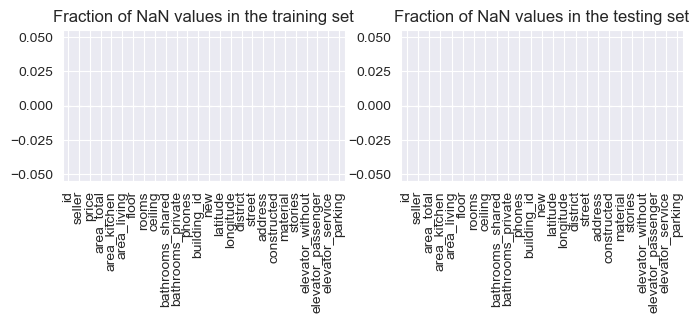

In [68]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 2), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data_train.price.isna().sum()}')
print(f'Training set features with any missing value: {data_train.isna().any().sum()}/{data_train.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

## Adding new features

### Bathrooms_total

In [69]:
data_train['bathrooms_total']=data_train['bathrooms_shared']+data_train['bathrooms_private']
data_test['bathrooms_total']=data_test['bathrooms_shared']+data_test['bathrooms_private']


### Distance to the city center:


In [70]:
# Distance from the city center
lat = data_train['latitude'].mean()
long = data_train['longitude'].mean()

data_train['center_dist'] = np.sqrt((data_train['latitude']-lat)**2 + (data_train['longitude']-long)**2)
data_test['center_dist'] = np.sqrt((data_test['latitude']-lat)**2 + (data_test['longitude']-long)**2)

# Let's create a predicition model
We define a score evaluation model :

In [71]:
def score_model():
    print("RMSLE SCORE RESULTS:")
    print(f'Train RMSLE: {RMSLE(y_true=y_train_small, y_pred=y_train_hat) :.4f}')
    print(f'Valid RMSLE: {RMSLE(y_true=y_test_small, y_pred=y_test_hat) :.4f}')
    print(f'Full dataset RMSLE: {RMSLE(y_true=y_train, y_pred=y_hat_full_training) :.4f}')

In [72]:
data_train_small, data_test_small = model_selection.train_test_split(data_train, test_size=0.33, stratify=np.log(data_train.price).round())
print(f'Split dataset into {len(data_train_small)} training samples and {len(data_test_small)} validation samples')

Split dataset into 15600 training samples and 7685 validation samples


We chose our features for the different models

In [73]:
features_xgb = ['area_total', 'latitude', 'longitude', 'area_living', 'floor', 'ceiling', 'district', 'constructed', 'material', 'stories', 'parking', 'center_dist','seller']
features_gbr = ['area_total', 'latitude', 'longitude', 'area_kitchen', 'area_living', 'floor', 'ceiling', 'district', 'constructed', 'material', 'stories', 'parking', 'center_dist','seller']
features_lgbm = ['seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'condition', 'phones','new', 'latitude', 'longitude', 'district']

## XGBoost Model

In [74]:
features = features_xgb

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train_small.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_test_small.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]

start = timer()

# Our model parameters
xgboost = xgb.XGBRegressor(learning_rate=0.05,n_estimators=1200,
                            max_depth=10, min_child_weight=1.0,
                            gamma=0, subsample=0.6,
                            colsample_bytree=0.4,
                            objective='reg:squaredlogerror', nthread=-1,
                            scale_pos_weight=1, seed=27,reg_alpha=0.00006)

# Fit model
xgboost.fit(X_train_small, y_train_small)

# Predict on the validation set
y_train_hat = xgboost.predict(X_train_small)
y_test_hat = xgboost.predict(X_test_small)
y_hat_full_training = xgboost.predict(X_train)

# Real prediction
xgboost.fit(X_train, y_train)
y_hat_xgb = xgboost.predict(X_test)

#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))

RMSLE SCORE RESULTS:
Train RMSLE: 0.0058
Valid RMSLE: 0.0080
Full dataset RMSLE: 0.0066
Time = 36.11461729999996


## LGBMRegressor

In [75]:
from lightgbm import LGBMRegressor

features = features_xgb

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train_small.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_test_small.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]

start = timer()

# Create model
lightgbm = LGBMRegressor(objective='regression', 
                        num_leaves=20, max_depth =7,
                        learning_rate=0.03, 
                        n_estimators=2000,
                        verbose=-1, metric= 'rmse',
                         loss = 'huber')

# Fit model to dataset
lightgbm.fit(X_train_small, y_train_small)

# Predict training
y_train_hat = lightgbm.predict(X_train_small)
y_test_hat = lightgbm.predict(X_test_small)
y_hat_full_training = lightgbm.predict(X_train)

#Real prediction
lightgbm.fit(X_train, y_train)
y_hat_lgbm = lightgbm.predict(X_test)


#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))

RMSLE SCORE RESULTS:
Train RMSLE: 0.0053
Valid RMSLE: 0.0077
Full dataset RMSLE: 0.0062
Time = 11.649046099999964


## Catboost

In [76]:
features = features_xgb

# Creating small datasets for research and RMSLE:
X_train_small = data_train_small[features]
y_train_small = np.log10(data_train_small.loc[X_train_small.index].price)

X_test_small = data_test_small[features]
y_test_small = np.log10(data_test_small.loc[X_test_small.index].price)

# Creating real datasets for actual predictions and submissions
X_train = data_train[features]
y_train = np.log10(data_train.loc[X_train.index].price)

X_test = data_test[features]

start = timer()

# Create model
catboost = CatBoostRegressor(n_estimators= 2000, learning_rate = 0.03,
                            thread_count=-1, depth=7,
                            silent= True, random_seed= 20,
                            bagging_temperature= 0.2, loss_function = 'RMSE')

# Fit model to dataset
catboost.fit(X_train_small, y_train_small)

# Predict training
y_train_hat = catboost.predict(X_train_small)
y_test_hat = catboost.predict(X_test_small)
y_hat_full_training = catboost.predict(X_train)

# Real prediction
catboost.fit(X_train, y_train)
y_hat_catboost = catboost.predict(X_test)

#Check score
score_model()

end = timer()
print('Time = ' + str(end - start))

RMSLE SCORE RESULTS:
Train RMSLE: 0.0055
Valid RMSLE: 0.0077
Full dataset RMSLE: 0.0063
Time = 51.6102588


## Stacked Cross Validation

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [78]:
# Create model
averaged_models = AveragingModels(models = (xgboost, lightgbm, catboost))

# Fit model
averaged_models.fit(X_train_small, y_train_small)


AveragingModels(models=(XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.05, max_delta_step=0,
                                     max_depth=10, min_child_weight=1.0,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=1200, n_jobs=4, nthread=-1,
                                     num_par...
                                     objective='reg:squaredlogerror',
                                     random_state=27, reg_alpha=6e-05,
                                     reg_lambda=1, scale_pos_weight=1, seed=27,
                                     subsample=0.6, tree_method='exact',
 

In [79]:
# Predict
y_train_hat = averaged_models.predict(X_train_small)
y_test_hat = averaged_models.predict(X_test_small)
y_hat_full_training = averaged_models.predict(X_train)

# Evaluate Score
score_model()

RMSLE SCORE RESULTS:
Train RMSLE: 0.0053
Valid RMSLE: 0.0076
Full dataset RMSLE: 0.0061


In [80]:
#Real prediction
averaged_models.fit(X_train, y_train)
y_hat_averaged = averaged_models.predict(X_test)

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = 10**y_hat_averaged

print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('averaged_submission.csv', index=False)

# Look at submitted csv
#print('\nLine count of submission')
#!wc -l averaged_submission.csv

#print('\nFirst 5 rows of submission')
#!head -n 5 averaged_submission.csv


Generated 9937 predictions


#### Conclusion

Stacking xgboost, LGBM and CatBoost gave us out best score on the public learderboard : 0.17405